In [8]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import pandas as pd
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path


%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("notebook")

#Dask setup
from multiprocessing.pool import ThreadPool
import dask
dask.config.set(pool=ThreadPool(int(os.environ['SLURM_CPUS_PER_TASK'])))

In [9]:
#Opening the zarr data
callset = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/callset.zarr', mode='r')
callset.tree(expand=False)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']
meta_data = pd.read_excel('../data/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')
baboon_samples = [x for x in meta_data.PGDP_ID if x.startswith('PD')] #  NB: to not get the SciAdvPaper samples
#Meta data for the sample present in the zarr data structure - Kasper has removed some of the samples.
samples_list = list(callset['chr1/samples'][:])
meta_data_samples = meta_data.loc[meta_data.PGDP_ID.isin(samples_list)].copy()
samples_callset_index = [samples_list.index(s) for s in meta_data_samples.PGDP_ID]
meta_data_samples['callset_index'] = samples_callset_index

In [12]:
#Opening the tables generated in heterozygosity_windows
het_counts_path = "../steps/het_counts_windows_{}.txt"
callability_percentage_path = "../steps/callability_windows_{}.txt"
het_list = []
call_list = []
for chrom in chromosomes:
    df = pd.read_table(het_counts_path.format(chrom), sep = " ")
    het_list.append(df)
    #df = pd.read_table(callability_percentage_path.format(chrom), sep = " ")
    #call_list.append(df)
het_df = pd.concat(het_list, axis=0)
#There are some columns with NaN, replacing those with 0
het_df["het"] = het_df["het"].fillna(0)
#Renaming columns to make horizonplot work
het_df.rename(columns = {"window": "start", "chr": "chrom", "PGDP_ID": "pop"}, inplace=True)

In [13]:
meta_data_samples

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
1,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
2,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1
3,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2
4,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,3
5,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,4
...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,155
213,213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,156
214,214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,157
215,215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,158


In [10]:
#Checking that the vcf and the zarr dataset contains the same number of heterozygous sites on the X in a specific individual
gt_zarr = callset["chr4/calldata/GT"]
gt = allel.GenotypeDaskArray(gt_zarr)
#Using individual PD_0201
x_zarr = []
x_vcf = []
id_list = []
sex_list = []
#Opening the vcf file to do the same
vcf_dir = "/faststorage/project/primatediversity/data/variants/"
vcf_suffix = ".variable.filtered.HF.snps.vcf.gz"
metainfo = "data/New_Papio.xlsx"
#Changed to check all
for index, individual in meta_data_samples.iterrows():
    #zarr
    ID = individual.PGDP_ID
    id_list.append(ID)
    sex_list.append(individual.Sex)
    specific_individual = meta_data_samples[meta_data_samples.PGDP_ID == ID].callset_index.values
    individual = (gt.take(specific_individual, axis=1))
    x_zarr.append(individual.count_het())
    
    #vcf
    vcf_callset = allel.read_vcf(vcf_dir+ID+vcf_suffix, region="chr4")
    vcf_gt = allel.GenotypeArray(vcf_callset["calldata/GT"])
    x_vcf.append(vcf_gt.count_het())
    print(index)

#So it can be seen that some sites are masked in the zarr dataset, but it has not added unknown sites.
zarr_vs_vsf = pd.DataFrame(list(zip(id_list, sex_list, x_zarr, x_vcf)), columns = ["PGDP_ID", "sex", "zarr_het", "vcf_het"])
zarr_vs_vsf.to_csv("../steps/zarr_vs_vcf_chr4.txt", sep = " ")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
55
56
57
58
59
60
61
62
63
64
65
66
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216


In [11]:
#There is a difference on the X 4, and 20
#There is not a difference on chr 4
zarr_vs_vsf

,PGDP_ID,sex,zarr_het,vcf_het
0,PD_0199,F,314928,317158
1,PD_0200,F,311839,313901
2,PD_0201,M,327877,330222
3,PD_0202,F,317881,320148
4,PD_0203,F,315374,317375
...,...,...,...,...
155,PD_0789,F,330201,332568
156,PD_0790,F,479876,482990
157,PD_0791,F,462584,465927
158,PD_0792,F,464394,467772


0.9932356342534152

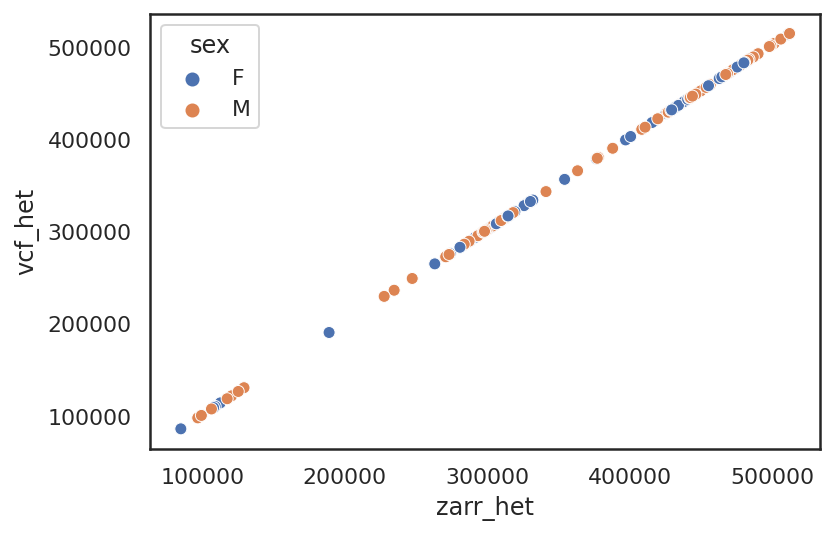

In [12]:
sns.scatterplot(data =zarr_vs_vsf, x = "zarr_het", y = "vcf_het", hue = "sex")
sum(x_zarr)/sum(x_vcf)

In [5]:
#Checking the sites that are removed from the zarr
merged_vcfs = "/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/merged_vcfs/"
vcf_callset = allel.read_vcf(merged_vcfs+"chrX.vcf.gz", region="chrX")
callset["chrX/variants/POS"]
vcf_callset["variants/POS"]
#
print(len(vcf_callset["variants/POS"])) #Are the same
print(len(callset["chrX/variants/POS"]))#Are the same

3609325
3609325


In [6]:
#Checking for PD_0201
ID = "PD_0201"
gt_zarr = callset["chrX/calldata/GT"]
gt = allel.GenotypeDaskArray(gt_zarr)
specific_individual = meta_data_samples[meta_data_samples.PGDP_ID == ID].callset_index.values
individual = (gt.take(specific_individual, axis=1))
zarr_het = individual.count_het()
zarr_length = len(individual)

In [7]:
#Merged vcf
merged_vcfs = "/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/merged_vcfs/"
merged_callset = allel.read_vcf(merged_vcfs+"chrX.vcf.gz", region="chrX")
merged_gt = allel.GenotypeArray(merged_callset["calldata/GT"])
individual_merged = (merged_gt.take(specific_individual, axis=1))
merged_het = individual_merged.count_het()
merged_length = len(individual_merged)

In [8]:
#Individual vcf
vcf_callset = allel.read_vcf(vcf_dir+ID+vcf_suffix, region="chrX")
vcf_gt = allel.GenotypeArray(vcf_callset["calldata/GT"])
vcf_het = vcf_gt.count_het()
vcf_length = len(vcf_gt)

In [9]:
#There is a match between merged and vcf in heterozygosity, while there is a number of site match between zarr and merged.
#This indicates that some part of the zarr creation process masks heterozygous sites.
print(zarr_het, merged_het, vcf_het)
print(zarr_length, merged_length, vcf_length)

60873 61000 61000
3609325 3609325 1303896


In [10]:
#Making an array and then comparing them to find sites which are masked.
het_sites_zarr = individual.is_het().compute() #Need to use compute here
het_sites_merged = individual_merged.is_het()

In [11]:
print(het_sites_zarr.sum(), het_sites_merged.sum())

60873 61000


In [12]:
#Finding the index positions
only_zarr = []
only_merged = []
for i in range(len(het_sites_zarr)):
    if het_sites_zarr[i] != het_sites_merged[i]:
        if het_sites_zarr[i] == True:
            only_zarr.append(i)
        else:
            only_merged.append(i)

In [13]:
print(len(only_zarr))
print(len(only_merged))

0
127


In [14]:
#As the merged and zarr have the same number of sites, this can be leveraged.
(individual.take(only_merged, axis=0)) #All sites in the zarr are ./.

,0
0,./.
1,./.
2,./.
...,...
124,./.
125,./.
126,./.


In [15]:
(individual_merged.take(only_merged, axis=0)) #All sites in the merged is 0/1

,0
0,0/1
1,0/1
2,0/1
...,...
124,0/1
125,0/1
126,0/1


In [16]:
#Callability data
called_interv = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/called_interv.zarr', mode='r')
#called_interv.tree(expand=False)

In [17]:
ID = "PD_0201"
pos = callset["chrX/variants/POS"]
pos_merged = [pos[i] for i in only_merged]

In [18]:
pos_merged

[108623,
 539880,
 741758,
 741808,
 1305292,
 1412572,
 1741041,
 1781050,
 1781062,
 2044379,
 2044382,
 3190741,
 3236753,
 3446897,
 4795850,
 7789941,
 10806656,
 16044196,
 25232596,
 25256117,
 25308958,
 27099781,
 27686514,
 35678308,
 36100691,
 36460261,
 36992522,
 37226965,
 38370609,
 42141126,
 44915686,
 45295239,
 45369774,
 46451789,
 47092615,
 48248413,
 49395560,
 49395583,
 49957984,
 50023591,
 50226700,
 50616932,
 51263439,
 52673131,
 53014698,
 54779622,
 54999108,
 54999438,
 55153039,
 55562103,
 56965264,
 57073072,
 57609565,
 57609693,
 58910419,
 58977522,
 59175174,
 59217832,
 59608145,
 59609449,
 59619060,
 61225220,
 61225242,
 65534201,
 66901627,
 69468772,
 70646749,
 73696109,
 75002287,
 75129838,
 78110590,
 79831129,
 82458949,
 83021426,
 89446040,
 91593795,
 91742519,
 101583618,
 108702328,
 109743679,
 111527015,
 112521224,
 112595857,
 112595901,
 113234396,
 113811134,
 116072026,
 116159003,
 116419688,
 119173757,
 119669246,
 1204

In [19]:
called_interv["PD_0201/chrX"][:]

array([[      244,       469],
       [      472,       474],
       [      475,       476],
       ...,
       [153367932, 153367995],
       [153368035, 153368039],
       [153368040, 153368048]], dtype=int32)

In [20]:
#Checking whether these sites are in called or uncalled intervs.
called_interv["PD_0201/chrX"][:]
index = 0
on_0 = []
between = []
on_1 = []
interv_found = []
for interv in called_interv["PD_0201/chrX"][:]:
    i0 = interv[0]
    i1 = interv[1]
    if index < len(pos_merged)-1:
        while pos_merged[index] <= i1:
            if pos_merged[index] < i0:
                index += 1
            elif pos_merged[index] == i0:
                on_0.append(pos_merged[index])
                index += 1
                interv_found.append([i0, i1])
            elif pos_merged[index] < i1:
                between.append(pos_merged[index])
                index += 1
                interv_found.append([i0, i1])
            elif pos_merged[index] == i1:
                on_1.append(pos_merged[index])
                index += 1
                interv_found.append([i0, i1])
#print(on_0, between, on_1)

In [28]:
#interv_found
print(on_0, between, on_1)
print(interv_found)

[108623, 741758, 741808, 1305292, 1412572, 1741041, 1781050, 1781062, 2044379, 2044382, 3190741, 3236753, 3446897, 4795850, 7789941, 10806656, 16044196, 25232596, 25256117, 25308958, 27099781, 27686514, 35678308, 36100691, 36460261, 36992522, 37226965, 38370609, 42141126, 44915686, 45295239, 45369774, 46451789, 47092615, 48248413, 49395560, 49395583, 49957984, 50023591, 50226700, 50616932, 51263439, 52673131, 53014698, 54779622, 54999108, 54999438, 55153039, 55562103, 56965264, 57073072, 57609565, 57609693, 58910419, 58977522, 59175174, 59608145, 59609449, 59619060, 61225220, 61225242, 65534201, 66901627, 69468772, 70646749, 73696109, 75002287, 75129838, 78110590, 79831129, 82458949, 83021426, 89446040, 91593795, 91742519, 101583618, 108702328, 109743679, 111527015, 112521224, 112595857, 112595901, 113234396, 113811134, 116072026, 116159003, 116419688, 119173757, 119669246, 120496468, 121522945, 123762281, 125928965, 127293007, 131697160, 135553553, 136244308, 136584885, 137939314, 139

In [22]:
#Checking that chrX isnt called the wrong name.
ID_list = ["PD_0200", "PD_0201"] #200 is F, 201 is M
for ID in ID_list:
    print(ID)
    for chrom in chromosomes:
        gt_zarr = callset["{}/calldata/GT".format(chrom)]
        gt = allel.GenotypeDaskArray(gt_zarr)
        specific_individual = meta_data_samples[meta_data_samples.PGDP_ID == ID].callset_index.values
        individual = (gt.take(specific_individual, axis=1))
        print(individual.count_het(), chrom)

PD_0200
377326 chr1
329329 chr2
318347 chr3
311839 chr4
346092 chr5
311169 chr6
301073 chr7
230915 chr8
224691 chr9
176083 chr10
218946 chr11
224816 chr12
207608 chr13
204241 chr14
184155 chr15
138960 chr16
180197 chr17
134541 chr18
134498 chr19
148744 chr20
107773 chrX
PD_0201
365391 chr1
320182 chr2
339873 chr3
327877 chr4
341551 chr5
316245 chr6
289739 chr7
274101 chr8
241263 chr9
180738 chr10
220700 chr11
228497 chr12
212366 chr13
205708 chr14
195664 chr15
134336 chr16
183983 chr17
139412 chr18
126527 chr19
144532 chr20
59996 chrX


In [36]:
#Not a match between obverved chrom lengths and last variable position.
chrom_length_all = pd.read_table("../data/macFas5.chrom.sizes.txt", names = ["chrom", "size"])
for chrom in chromosomes:
    pos = callset["{}/variants/POS".format(chrom)]
    print(pos[-1])
    print(chrom_length_all.loc[chrom_length_all.chrom == chrom].values)

223616938
[['chr1' 227556264]]
196197264
[['chr2' 192460366]]
185288920
[['chr3' 192294377]]
169962085
[['chr4' 170955103]]
187314918
[['chr5' 189454096]]
179083632
[['chr6' 181584905]]
169868557
[['chr7' 171882078]]
145679099
[['chr8' 146850525]]
134123906
[['chr9' 133195287]]
99513955
[['chr10' 96509753]]
133065668
[['chr11' 137757926]]
130038526
[['chr12' 132586672]]
108736597
[['chr13' 111193037]]
128054866
[['chr14' 130733371]]
113280646
[['chr15' 112612857]]
79627028
[['chr16' 80997621]]
95429202
[['chr17' 96864807]]
74473779
[['chr18' 75711847]]
58315098
[['chr19' 59248254]]
77137320
[['chr20' 78541002]]
153366679
[['chrX' 152835861]]


389.5844155844156 147.5 533313.5124352771


<AxesSubplot:xlabel='window', ylabel='PD_0201'>

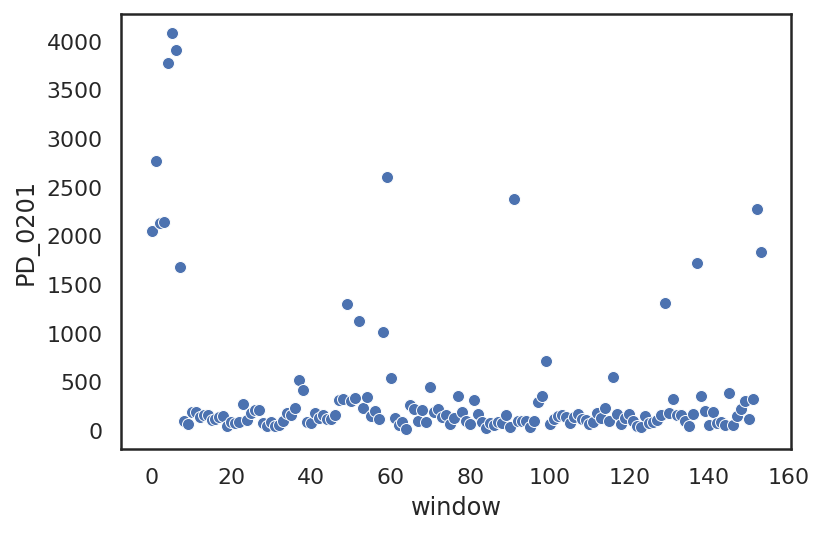

In [24]:
#Diving into PD_0201
x_data = het_counts_windows.loc[het_counts_windows.chr == "chrX"]
single_data = x_data["PD_0201"]
s_mean = single_data.mean()
s_median = single_data.median()
s_variance = single_data.var()
print(s_mean, s_median, s_variance)
sns.scatterplot(y = single_data, x =  x_data["window"])

<AxesSubplot:xlabel='window', ylabel='PD_0201'>

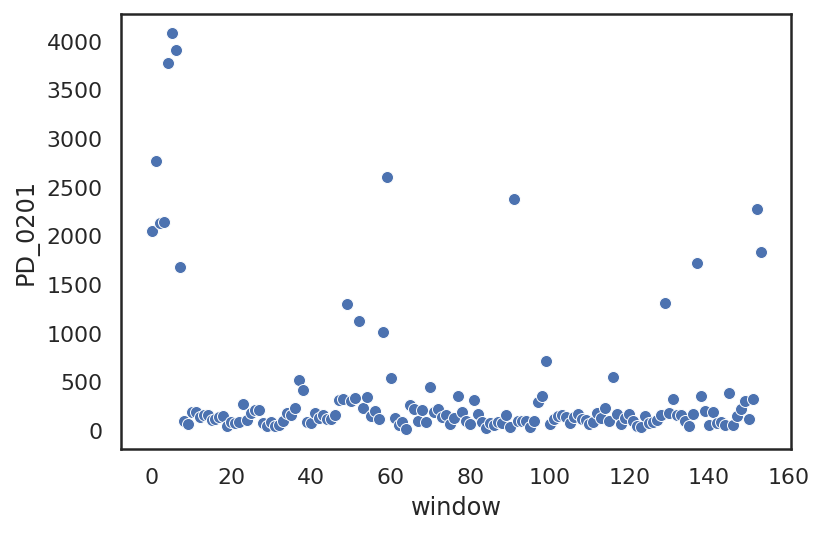

In [25]:
#Is the heterozygosity mostly in the edges?
sns.scatterplot(y = single_data, x =  x_data["window"])
#Answer: Yes, but there is also areas in the middle containing high heterozygosity, and most windows have some

In [26]:
#Finding the area in PD_0201 with most heterozygosity
max_pos = single_data.values.argmax()
single_data[:10]

2701    2044
2702    2765
2703    2135
2704    2145
2705    3774
2706    4079
2707    3913
2708    1674
2709      97
2710      60
Name: PD_0201, dtype: int64

In [168]:
#Investigating a small window to detect in which way it is weird.
pos = allel.SortedIndex(callset["chrX/variants/POS"])
loc_region = pos.locate_range(5000000, 6000000)
gt_zarr = callset["chrX/calldata/GT"]
gt_region = allel.GenotypeDaskArray(gt_zarr[loc_region])
specific_individual = meta_data_samples[meta_data_samples.PGDP_ID == "PD_0201"].callset_index.values
individual = gt_region.take(specific_individual, axis=1)
individual
#it is equivalent to what my table contained.

,0
0,0/0
1,0/0
2,0/0
...,...
33373,0/0
33374,0/0
33375,0/0


In [185]:
#Manual check that heterozygous sites are detected.
print(individual.count_het())
het_or_not = individual.is_het()
het = []
for i in range(len(het_or_not)): #Changing it to index positions, the bool was troublesome.
    if het_or_not[i] == True:
        het.append(i)
individual.take(het, axis = 0)

0


KeyboardInterrupt: 

In [136]:
#Checking whether heterozygous sites on X in males have some kind of bias, such as abnormal depth.
vcf_dir = "/faststorage/project/primatediversity/data/variants/"
vcf_suffix = ".variable.filtered.HF.snps.vcf.gz"
metainfo = "data/New_Papio.xlsx"
vcf_callset = allel.read_vcf(vcf_dir+"PD_0201"+vcf_suffix, region="chrX")
vcf_callset.keys()

dict_keys(['samples', 'calldata/GT', 'variants/ALT', 'variants/CHROM', 'variants/FILTER_PASS', 'variants/ID', 'variants/POS', 'variants/QUAL', 'variants/REF'])

In [137]:
vcf_callset["variants/REF"]

array(['G', 'T', 'T', ..., 'T', 'C', 'A'], dtype=object)

In [138]:
qual = vcf_callset["variants/QUAL"]
gt = allel.GenotypeArray(vcf_callset["calldata/GT"])

In [139]:
het_or_not = gt.is_het()
het = []
not_het = []
for i in range(len(het_or_not)): #Changing it to index positions, the bool was troublesome.
    if het_or_not[i] == True:
        het.append(i)
    else:
        not_het.append(i)
    if i % 100000 == 0:
        print(i)
hom = []
hom_or_not = gt.is_hom()
for i in range(len(hom_or_not)):
    if hom_or_not[i] == True:
        hom.append(i)
    if i % 100000 == 0:
        print(i)
        
het_sites = gt.take(het, axis = 0)
hom_sites = gt.take(not_het, axis = 0)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000


In [140]:
hom_or_not = gt.is_hom()
hom_or_not.sum()


1242896

379.66522

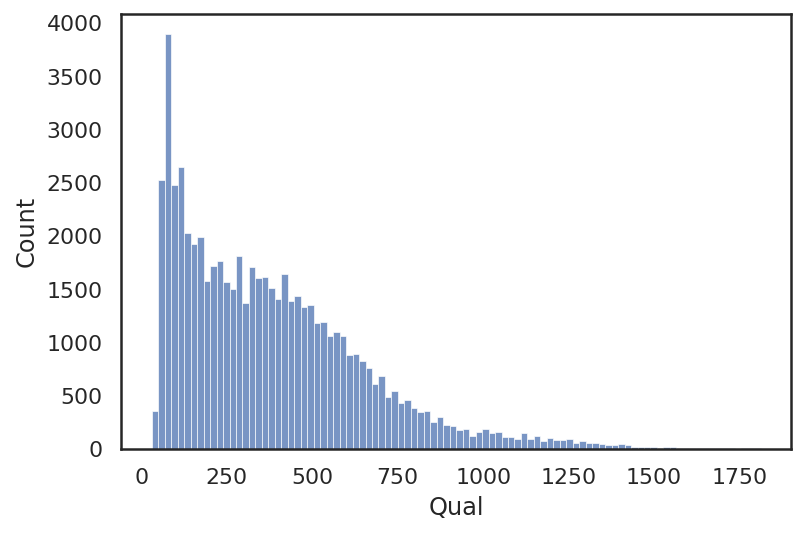

In [141]:
qual_het = qual.take(het, axis = 0)
hist = sns.histplot(x = qual_het)
hist.set(xlabel="Qual")
qual_het.mean()

[Text(0.5, 0, 'Qual')]

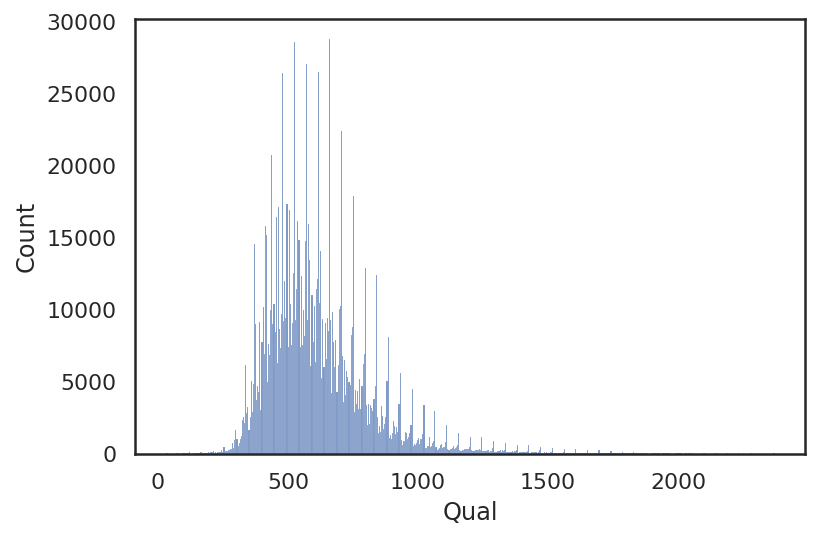

In [142]:
qual_not_het = qual.take(not_het, axis = 0)
hist = sns.histplot(x = qual_not_het)
hist.set(xlabel="Qual")

In [143]:
#Checking hom vs het with having the border regions removed.
vcf_dir = "/faststorage/project/primatediversity/data/variants/"
vcf_suffix = ".variable.filtered.HF.snps.vcf.gz"
metainfo = "data/New_Papio.xlsx"
vcf_callset = allel.read_vcf(vcf_dir+"PD_0201"+vcf_suffix, region="chrX:10000000-150000000")
qual = vcf_callset["variants/QUAL"]
gt = allel.GenotypeArray(vcf_callset["calldata/GT"])

In [144]:
het_or_not = gt.is_het()
het = []
not_het = []
for i in range(len(het_or_not)): #Changing it to index positions, the bool was troublesome.
    if het_or_not[i] == True:
        het.append(i)
    else:
        not_het.append(i)
    if i % 100000 == 0:
        print(i)
hom = []
hom_or_not = gt.is_hom()
for i in range(len(hom_or_not)): #Changing it to index positions, the bool was troublesome.
    if hom_or_not[i] == True:
        hom.append(i)
    if i % 100000 == 0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


361.05988

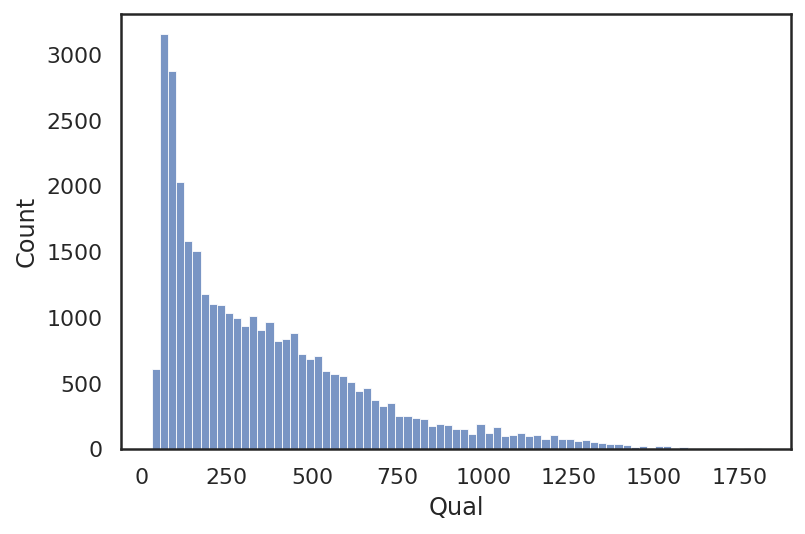

In [145]:
qual_het = qual.take(het, axis = 0)
hist = sns.histplot(x = qual_het)
hist.set(xlabel="Qual")
qual_het.mean()

<AxesSubplot:ylabel='Count'>

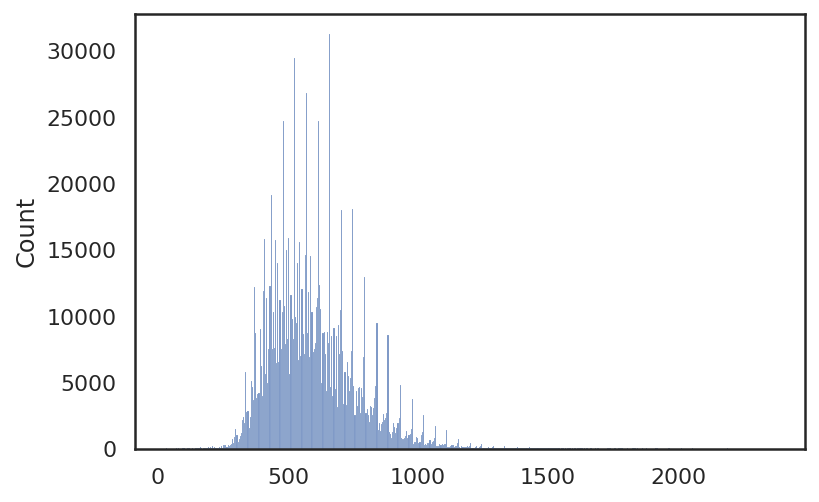

In [108]:
qual_not_het = qual.take(not_het, axis = 0)
sns.histplot(x = qual_not_het)

In [184]:
#Using the data which is present for every individual, that is calldata
#And then looking at the stats for heterozygous sites vs all other sites.
gt_zarr = callset["chrX/calldata/GT"]
gt = allel.GenotypeDaskArray(gt_zarr)
individual = gt.take(specific_individual, axis=1)
het_or_not = individual.is_het()
het = []
not_het = []
for i in range(len(het_or_not)): #Changing it to index positions, the bool was troublesome.
    if het_or_not[i] == True:
        het.append(i)
    else:
        not_het.append(i)
    if i % 10000 == 0:
        print(i)

KeyError: 'chrX/calldata/GT'

In [ ]:
#First looking at AD and DP
ad_zarr = allel.GenotypeDaskArray(callset["chrX/calldata/AD"])
dp_zarr = allel.GenotypeDaskArray(callset["chrX/calldata/DP"])
ad_i = ad_zarr.take(specific_individual, axis=1)
dp_i = dp_zarr.take(specific_individual, axis=1)

In [47]:
#Plotting of raw heterozygosity
x_data = het_counts_windows.loc[het_counts_windows.chr == "chrX"]
x_count = []
id_list = []
sex_list = []
for i, row in meta_data_samples.iterrows():
    ID = row.PGDP_ID
    x = x_data[ID]
    x_count.append(x.sum())
    id_list.append(ID)
    sex_list.append(row.Sex)

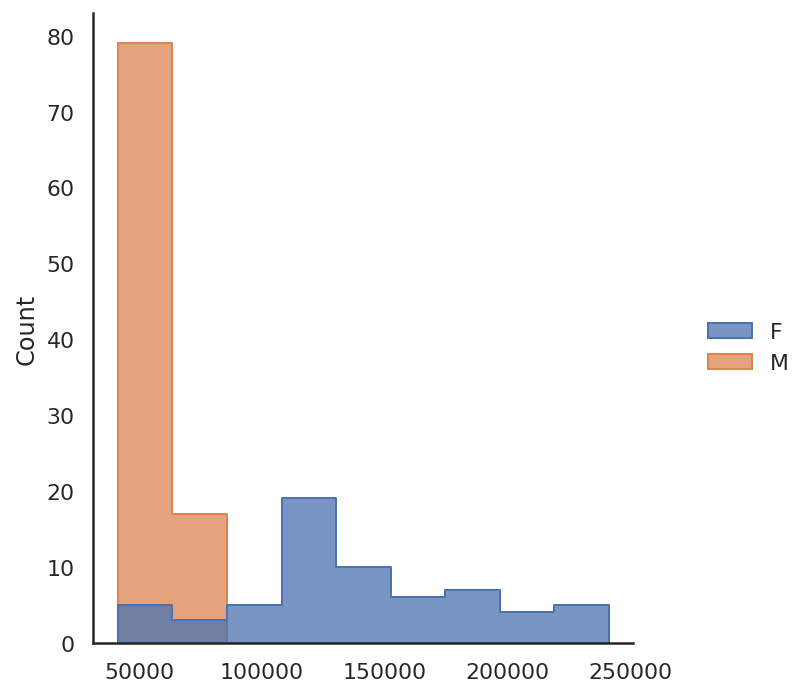

In [70]:
sns.displot(x = x_count, hue = sex_list, element = "step")